In [1]:
try:
    %matplotlib inline # can also use notebook or nbagg
except:
    pass
from dune.generator import builder
import math
import numpy as np
import scipy.sparse.linalg
import scipy.optimize
import dune.grid
import dune.fem
from dune.fem.plotting import plotPointData as plot
import dune.create as create

from ufl import TestFunction, TrialFunction, SpatialCoordinate, ds, dx, inner, grad

grid = create.grid("ALUConform", dune.grid.cartesianDomain([0, 0], [1, 1], [8, 8]), dimgrid=2)
space = create.space("lagrange", grid, dimrange=1, order=1, storage='fem')

d = 0.001
p = 1.7

u = TrialFunction(space)
v = TestFunction(space)
x = SpatialCoordinate(space.cell())

rhs = (x[0] + x[1]) * v[0]
a = (pow(d + inner(grad(u), grad(u)), (p-2)/2)*inner(grad(u), grad(v)) \
    + inner(u, v)) * dx + 10*inner(u, v) * ds
b = rhs * dx + 10*rhs * ds

scheme = create.scheme("h1", space, a == b, \
       parameters=\
       {"fem.solver.newton.linabstol": 1e-10,
        "fem.solver.newton.linreduction": 1e-10,
        "fem.solver.newton.verbose": 1,
        "fem.solver.newton.linear.verbose": 0})

# create a discrete solution over this space - will be initialized with zero by default
uh = create.function("discrete", space, name="solution")

In the following we implement a simple Newton solver: given an initial guess $u^0$ (here taken to be zero) solve for $n\geq 0$.
\begin{align*}
   u^{n+1} = u^n - DS(u^n)(S(u^n)-g)
\end{align*}
Where $g$ is a discrete function containing the boundary values in the Dirichlet nodes and zero otherwise.

Usually this would be automatically taken care of in Fempy by `scheme.solve`, however this time we will use the call operator on the `scheme` to compute $S(u^n)$ as well as `scheme.assemble` to get a copy of the system matrix in form of a SciPy sparse row matrix. Note that this method is not available for all storage types.

iterations (0) 8.204874174739299
iterations (1) 0.7706154521999533
iterations (2) 0.005643744976839006
iterations (3) 2.3213588581809258e-06
iterations (4) 5.45734062602357e-13


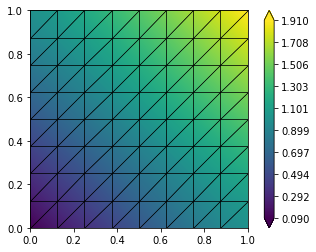

In [2]:
# create a copy of uh for the residual
res = uh.copy() 

# create numpy vectors to store uh and res
sol_coeff = uh.as_numpy
res_coeff = res.as_numpy
n = 0

while True:
    scheme(uh, res)
    absF = math.sqrt( np.dot(res_coeff,res_coeff) )
    print("iterations ("+str(n)+")",absF)
    if absF < 1e-10:
        break
    matrix = scheme.assemble(uh)
    sol_coeff -= scipy.sparse.linalg.spsolve(matrix, res_coeff)
    n += 1

plot(uh)

We can redo the above computation using a Newton-Krylov solver from SciPy. We do this by constructing a class `Df` containing the derivative of the operator. This would normally be done within DUNE, but here we do it purely through python. 

0:  |F(x)| = 0.770615; step 1; tol 0.00793915
1:  |F(x)| = 0.00564375; step 1; tol 4.82727e-05
2:  |F(x)| = 2.32135e-06; step 1; tol 1.52261e-07
3:  |F(x)| = 5.50494e-13; step 1; tol 5.06137e-14


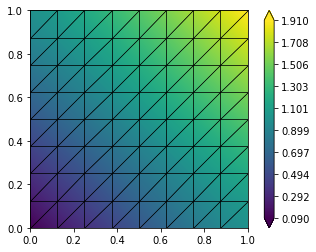

In [3]:
# let's first set the solution back to zero - since it already contains the right values
uh.clear()
def f(x_coeff):
    x = space.numpyFunction(x_coeff, "tmp")
    scheme(x,res)
    return res_coeff
# class for the derivative DS of S
class Df(scipy.sparse.linalg.LinearOperator):
    def __init__(self,x_coeff):
        self.shape = (sol_coeff.shape[0],sol_coeff.shape[0])
        self.dtype = sol_coeff.dtype
        # the following converts a given numpy array
        # into a discrete function over the given space
        x = space.numpyFunction(x_coeff, "tmp")
        # store the assembled matrix
        self.jac = scheme.assemble(x)
    # reassemble the matrix DF(u) given a dof vector for u
    def update(self,x_coeff,f):
        x = space.numpyFunction(x_coeff, "tmp")
        # Note: the following does produce a copy of the matrix
        # and each call here will reproduce the full matrix
        # structure - no reuse possible in this version
        self.jac = scheme.assemble(x)
    # compute DS(u)^{-1}x for a given dof vector x
    def _matvec(self,x_coeff):
        return scipy.sparse.linalg.spsolve(self.jac, x_coeff)

# call the newton krylov solver from scipy
sol_coeff[:] = scipy.optimize.newton_krylov(f, sol_coeff,
            verbose=1, f_tol=1e-8,
            inner_M=Df(sol_coeff))

plot(uh)

We can also use the package `petsc4py` to solve the problem.

__Note__: make sure that `dune` has been configured using the same version of `petsc` used for `petsc4py`

The first step is to change the storage in the space. Since also requires setting up the scheme and siscrete functions again to use the new storage structure.

We can directly use the `petsc` solvers by invoking `solve` on the scheme as before.

{'converged': '1', 'iterations': '4', 'linear_iterations': '50'}


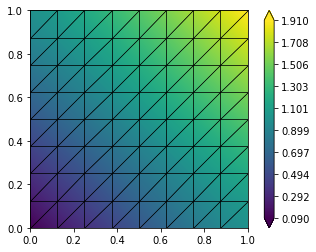

In [4]:
try:    
    import petsc4py, sys
    from petsc4py import PETSc
    petsc4py.init(sys.argv)
    space = create.space("lagrange", grid, dimrange=1, order=1, storage='petsc')
    scheme = create.scheme("h1", space, a==b,
                            parameters={"petsc.preconditioning.method":"sor"})
    # first we will use the petsc solver available in the `dune-fem` package (using the sor preconditioner)
    uh, info = scheme.solve()
    print(info)
    plot(uh)
except ImportError:
    print("petsc4py could not be imported")
    petsc4py = False

Next we will implement the Newton loop in Python using `petsc4py` to solve the linear systems
Need to auxiliary function and set `uh` back to zero.
We can access the `petsc` vectors by calling `as_petsc` on the discrete function. Note that this property will only be available if the discrete function is an element of a space with storage `petsc`.
The method `assemble` on the scheme now returns the sparse `petsc` matrix and so we can directly use the `ksp` class from `petsc4py`:

iterations (0) 8.204874174739299
iterations (1) 0.7706125382169096
iterations (2) 0.005643532394064518
iterations (3) 2.3211404033616676e-06
iterations (4) 7.1786101941033674e-12


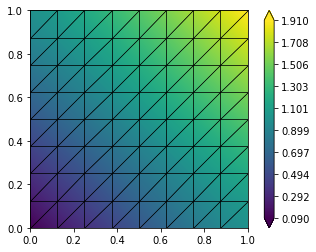

In [5]:
if petsc4py:
    uh.clear()
    res = uh.copy() 

    sol_coeff = uh.as_petsc
    res_coeff = res.as_petsc

    ksp = PETSc.KSP()
    ksp.create(PETSc.COMM_WORLD)
    # use conjugate gradients method
    ksp.setType("cg")
    # and incomplete Cholesky
    ksp.getPC().setType("icc")

    n = 0
    while True:
        scheme(uh, res)
        absF = math.sqrt( res_coeff.dot(res_coeff) )
        print("iterations ("+str(n)+")",absF)
        if absF < 1e-10:
            break
        matrix = scheme.assemble(uh)
        ksp.setOperators(matrix)
        ksp.setFromOptions()
        ksp.solve(res_coeff, res_coeff)
        sol_coeff -= res_coeff
        n += 1
    plot(uh)

Finally we we will use `petsc`'s non-linear solvers (the `snes` classes) directly:

0 8.204874174739299
1 0.7706125382169102
2 0.00564353239406432
3 2.321140403375469e-06
4 7.1786101941033674e-12


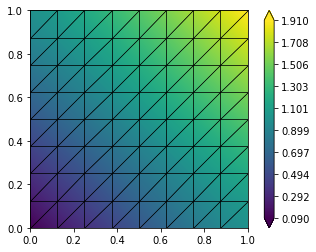

In [6]:
if petsc4py:
    uh.clear()
    def f(snes, X, F):
        inDF = space.petscFunction(X)
        outDF = space.petscFunction(F)
        scheme(inDF,outDF)
    def Df(snes, x, m, b):
        inDF = space.petscFunction(x)
        matrix = scheme.assemble(inDF)
        m.createAIJ(matrix.size, csr=matrix.getValuesCSR())
        b.createAIJ(matrix.size, csr=matrix.getValuesCSR())
        return PETSc. Mat. Structure.SAME_NONZERO_PATTERN

    snes = PETSc.SNES().create()
    snes.setMonitor(lambda snes,i,r:print(i,r,flush=True))
    snes.setFunction(f, res_coeff)
    # snes.setUseMF(True)
    snes.setJacobian(Df,matrix,matrix)
    snes.getKSP().setType("cg")
    snes.setFromOptions()
    snes.solve(None, sol_coeff)
    plot(uh)

__Note__: 
The method `as_numpy, as_petsc` (returning the `dof` vector either as a `numpy` or a `petsc` vector) do not lead to a copy of the data and the same is true for the `numpyFunction` and the `petscFunction` methods on the space. In the `numpy` case we can use `Python`'s buffer protocol to use the same underlying storage. In the case of `petsc` the underlying `Vec` can be shared. In the case of matrices the situation is not yet as clear: `scheme.assemble` returns a copy of the data in the `scipy` case while the `Mat` structure is shared between `c++` and  `Python` in the `petsc` case. But at the time of writing it is not possible to pass in the `Mat` structure to the `scheme.assemble` method from the outside. That is why it is necessary to copy the data when using the `snes` non linear solver as seen above.